# Genetic Algorithm

This notebook analyzes more closely possible genetic operators for the GA designed to solve the problem of *learning abstractions*. A detailed description of the problem is given in the previous notebook; here we just run a few empiricial analyses and present some theoretical considerations.

## Setup

We import the basic libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

from tqdm.notebook import tqdm

import src.utils as ut
import src.geneticalgorithm as ga
import src.learning as lng

We first set reproducibility and output constants.

In [2]:
np.random.seed(1985)

np.set_printoptions(precision=4,suppress=True)

We also define some problem specific setting, taken from the previous notebook. Specifically we consider a population where each individual encodes three binary surjective matrices with the following dimensions.

In [3]:
MATRICES = [[3,4],[2,3],[2,2]]

N_ITER = 10**5

## Formal introduction

In this notebook we want to analyze how genetic operators allow us to explore the space of solutions. We will start focusing on the main operator of *mutation*.

### Mutation operator

We define a mutation operator $\mathbf{M}$ as a unary individual-level operator that transforms one solution into another solution. Formally: 

$$
\mathbf{M}: \mathcal{X} \rightarrow \mathcal{X},
$$

where $\mathcal{X}$ is the solution space. We are interested in examining the behaviour of the iterative application of this operator:

$$
\mathbf{M}^n(x) = \mathbf{M}(\mathbf{M}(....\mathbf{M}(x)...))),
$$

for $x \in \mathcal{X}$. This chain defines a random walk in the solution space. We may be interested in different properties:
1. Does the walk cover the whole space uniformly?
2. Is the walk sensitive to the starting point?

A couple of remarks:
- In general it may not be desirable for a whole genetic algorithm to perform a uniform sampling in the solution space. However, the sampling probability distribution can be transformed and biased via fitness evaluation. Without fitness and selection, it may be reasonable to require the mutation operator itself to be uniform.
- A genetic algorithm instantiates a population of individuals. Applying the mutation operator to a population boils down to the application of the unary operator to multiple individuals in parallel. However, notice that this may change the statistical properties of the exploration. For instance, if the mutation operator perform a highly localized walk, having multiple distributed starting point may significantly improve the coverage of the procedure.

## Simulations for mutation operators

We run a few simulations to observe how the random walk implied by a mutation operator cover the solution space.

To do this, we first define a couple of support data structure.

We first define *sample_space*, an indexable list to efficiently sample admissible solutions.

In [4]:
sets = []
for m in MATRICES:
    all_surj_matrices = lng.get_all_surjective_matrices(m[1], m[0])
    all_surj_vectors = [ut.map_matrix2vect(i) for i in all_surj_matrices]
    sets.append(all_surj_vectors)
sample_space = list(itertools.product(*sets))
sample_space_dim = len(sample_space)

Next we define *flat_sample_space*, a set of hashable flattened solutions that we will use to verify containment and to access a counter dictionary. We provide also a small helper function, *vectors_to_set()*, that transforms a solution (list of array) inot a dictionary key (a flattened tuple).

In [5]:
def vectors_to_set(vs):
    return tuple(np.concatenate(vs))

In [6]:
flat_sample_space = set([vectors_to_set(i) for i in sample_space])

We also define a function to get an empty counter and the dimension of the sample space. Notice that our statistics account for non-admissible solution in an additional bin.

In [7]:
def get_counter():
    counter = dict.fromkeys(flat_sample_space,0)
    counter['Not Admissible'] = 0
    return counter

sample_space_dim = len(sample_space)

### Mutation 0: Pure sampling

The first mutation operator is a basic uniform sampling from $\mathcal{X}$. This mutation operator is not very meaningful because (i) normally we can not sample uniformly from $\mathcal{X}$; (ii) the implied random walk is trivially uniform. Yet, this simulation will work as a failsafe experiment.

In [8]:
counter = get_counter()
for i in tqdm(range(N_ITER)):
    sample = sample_space[np.random.choice(sample_space_dim)]    
    counter[vectors_to_set(sample)] += 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Non-admissible solution considered: 0
Solution never considered: 0 (0.0%)
Theoretical expected value: 231.4814814814815
Empirical mean and std: 231.4814814814815 +- 15.524909185326013
Empirical min and max: 185 --- 285


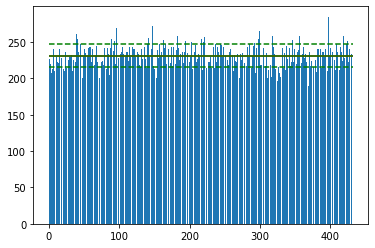

In [9]:
vals = list(counter.values())[0:-1]
print('Non-admissible solution considered: {0}'.format(counter['Not Admissible']))
print('Solution never considered: {0} ({1}%)'.format(np.sum(np.array(vals)==0), np.sum(np.array(vals)==0)*100/sample_space_dim))

plt.bar(np.arange(sample_space_dim), vals)

plt.hlines(N_ITER/sample_space_dim,0,sample_space_dim,color='red',linestyles='solid')
print('Theoretical expected value: {0}'.format(N_ITER/sample_space_dim))

plt.hlines(np.mean(vals),0,sample_space_dim,color='green',linestyles='solid')
plt.hlines(np.mean(vals)+np.std(vals),0,sample_space_dim,color='green',linestyles='dashed')
plt.hlines(np.mean(vals)-np.std(vals),0,sample_space_dim,color='green',linestyles='dashed')
print('Empirical mean and std: {0} +- {1}'.format(np.mean(vals),np.std(vals)))
print('Empirical min and max: {0} --- {1}'.format(np.min(vals),np.max(vals)))

Of course, the distribution is noisy but vaguely uniform (the solid line defines the expected value under the uniform distribution).

### Mutation 1: Random variation

We now consider the basic mutation operator we have used before, where with a small probability ($MUTATION\_RATE$) an entry in an individual is randomly changed. This mutation changes an entry arbitrarily, without taking into account the constraint of surjectivity.

In [10]:
MUTATION_RATE = .1

In [11]:
def mutate(x,verbose=False):
    for i in range(len(MATRICES)):
        for j in range(len(x[i])):
            if np.random.rand() < MUTATION_RATE:
                x[i][j] = np.random.randint(MATRICES[i][0])   
    return x

We run our sampling and plot the results.

In [12]:
x = ga.generate_random_population(1,MATRICES)[0]
counter = get_counter()

for i in tqdm(range(N_ITER)):
    x = mutate(x)
    if vectors_to_set(x) in flat_sample_space:
        counter[vectors_to_set(x)] += 1
    else:
        counter['Not Admissible'] += 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Non-admissible solution considered: 83333 (83.333%)
Solution never considered: 0 (0.0%)
Empirical mean and std: 38.58101851851852 +- 12.40381179761964
Empirical min and max: 6 --- 77


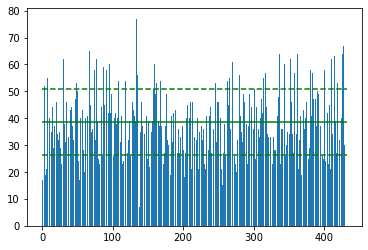

In [13]:
vals = list(counter.values())[0:-1]
print('Non-admissible solution considered: {0} ({1}%)'.format(counter['Not Admissible'], counter['Not Admissible']*100/N_ITER))
print('Solution never considered: {0} ({1}%)'.format(np.sum(np.array(vals)==0), np.sum(np.array(vals)==0)*100/sample_space_dim))

plt.bar(np.arange(sample_space_dim), vals)

plt.hlines(np.mean(vals),0,sample_space_dim,color='green',linestyles='solid')
plt.hlines(np.mean(vals)+np.std(vals),0,sample_space_dim,color='green',linestyles='dashed')
plt.hlines(np.mean(vals)-np.std(vals),0,sample_space_dim,color='green',linestyles='dashed')
print('Empirical mean and std: {0} +- {1}'.format(np.mean(vals),np.std(vals)))
print('Empirical min and max: {0} --- {1}'.format(np.min(vals),np.max(vals)))

A first striking observation is that this operator leads us to spend most of the time ($\sim 83\%$) outside the space of admissible solutions. On the positive side, though, all solutions are explored. However, the sample is too small to assess whether the random walk is uniform.

### Mutation 2: Random variation with repair

We now try to patch the wasteful mutation operator with a *repair* loop: every time a mutation is proposed, if the mutation generates a non-admissible solution, an alternative mutation is requested.

In [14]:
def is_individual_admissible(x):
    for i in range(len(x)):
        xmatrix = ut.map_vect2matrix(x[i],MATRICES[i][0])
        if not ut.is_matrix_surjective(xmatrix):
            return False
    return True

In [15]:
def mutate_with_repair(x,verbose=False):
    for i in range(len(MATRICES)):
        for j in range(len(x[i])):
            if np.random.rand() < MUTATION_RATE:
                x[i][j] = np.random.randint(MATRICES[i][0])
                while(not is_individual_admissible(x)):
                    x[i][j] = np.random.randint(MATRICES[i][0])
    return x

We run the simulation and plot the results.

In [16]:
x = ga.generate_random_population(1,MATRICES)[0]
while(not is_individual_admissible(x)):
    x = ga.generate_random_population(1,MATRICES)[0]
counter = get_counter()

for i in tqdm(range(N_ITER)):
    x = mutate_with_repair(x)
    if vectors_to_set(x) in flat_sample_space:
        counter[vectors_to_set(x)] += 1
    else:
        counter['Not Admissible'] += 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Non-admissible solution considered: 0 (0.0%)
Solution never considered: 216 (50.0%)
Empirical min and max: 0 --- 700
Empirical mean and std: 231.4814814814815 +- 238.13606760442968


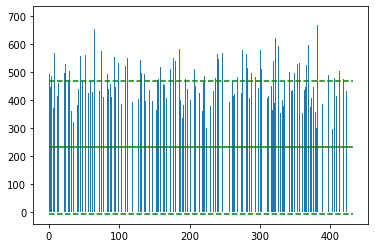

In [17]:
vals = list(counter.values())[0:-1]
print('Non-admissible solution considered: {0} ({1}%)'.format(counter['Not Admissible'], counter['Not Admissible']*100/N_ITER))
print('Solution never considered: {0} ({1}%)'.format(np.sum(np.array(vals)==0), np.sum(np.array(vals)==0)*100/sample_space_dim))
print('Empirical min and max: {0} --- {1}'.format(np.min(vals),np.max(vals)))

plt.bar(np.arange(sample_space_dim), vals)

plt.hlines(np.mean(vals),0,sample_space_dim,color='green',linestyles='solid')
plt.hlines(np.mean(vals)+np.std(vals),0,sample_space_dim,color='green',linestyles='dashed')
plt.hlines(np.mean(vals)-np.std(vals),0,sample_space_dim,color='green',linestyles='dashed')
print('Empirical mean and std: {0} +- {1}'.format(np.mean(vals),np.std(vals)))

This new solution avoids generating non-admissible solution; however, the truth is that the algorithm still generates non-admissible solution, it just avoids passing them on until a good one is found. This looping cycle causes the mutation operators to be significantly slower (see the time output of *tqdm*: less than a second for the original operator and more than $10$ seconds for the operator with repair).

The other striking feature is that a large number of solution (exactly half) are never considered. This may be surprising at first, but it is actually due to the presence of a square matrix: no single entry change in a square matrix may be introduced without causing it to be non-surjective. Thus the last matrix, with shape $2 \times 2$ is never modified.

Two conclusions are of interest:
- We want to design mutation and repair together in a smart way. Our solution does not reduce complexity: it trades sample efficiency (number of admissible solution) with time efficiency (running time).
- We want to design repair so that it does not prevent the exploration of the solution space.

### Mutation 3: Random variation with constraint-awareness

We now implement a mutation that, every time a mutation occurs, select one among two routines that preserve surjectivity: (i) swapping of two values; (ii) random substitution of a repeated entry.

In [18]:
def swap(v): 
    idxs = np.random.choice(len(v),size=2,replace=False)
    
    tmp = v[idxs[0]]
    v[idxs[0]] = v[idxs[1]]
    v[idxs[1]] = tmp
    
    return v

In [19]:
def substitute(v,dom):
    repeated_elements = list(set([x for x in v if list(v).count(x) > 1]))
    if repeated_elements:
        element_to_subst = repeated_elements[np.random.choice(len(repeated_elements))]
        idx_element_to_subst = np.random.choice(np.argwhere(v==element_to_subst).flatten())
        v[idx_element_to_subst] = np.random.randint(dom)
    return v

In [20]:
def mutate_with_constraint(x,verbose=False):
    for i in range(len(MATRICES)):
        if np.random.rand() < MUTATION_RATE:
            if np.random.rand() < .5:
                swap(x[i])
            else:
                substitute(x[i], MATRICES[i][0])
    return x

We run the simulation and plot the results.

In [21]:
x = ga.generate_random_population(1,MATRICES)[0]
while(not is_individual_admissible(x)):
    x = ga.generate_random_population(1,MATRICES)[0]
counter = get_counter()

for i in tqdm(range(N_ITER)):
    x = mutate_with_constraint(x)
    if vectors_to_set(x) in flat_sample_space:
        counter[vectors_to_set(x)] += 1
    else:
        counter['Not Admissible'] += 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Non-admissible solution considered: 0 (0.0%)
Solution never considered: 0 (0.0%)
Empirical min and max: 88 --- 420
Empirical mean and std: 231.4814814814815 +- 54.43267698479598


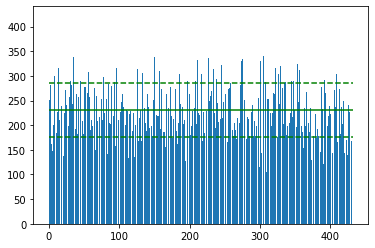

In [22]:
vals = list(counter.values())[0:-1]
print('Non-admissible solution considered: {0} ({1}%)'.format(counter['Not Admissible'], counter['Not Admissible']*100/N_ITER))
print('Solution never considered: {0} ({1}%)'.format(np.sum(np.array(vals)==0), np.sum(np.array(vals)==0)*100/sample_space_dim))
print('Empirical min and max: {0} --- {1}'.format(np.min(vals),np.max(vals)))

plt.bar(np.arange(sample_space_dim), vals)

plt.hlines(np.mean(vals),0,sample_space_dim,color='green',linestyles='solid')
plt.hlines(np.mean(vals)+np.std(vals),0,sample_space_dim,color='green',linestyles='dashed')
plt.hlines(np.mean(vals)-np.std(vals),0,sample_space_dim,color='green',linestyles='dashed')
print('Empirical mean and std: {0} +- {1}'.format(np.mean(vals),np.std(vals)))

This solution improves on the trade-off described above in the sense that it generates only admissible solutions in  a more reasonable amount of time ($\sim 3$ seconds). 

Although all solutions are explored, the distribution looks less uniform, due to two routines (*swap()* and *substitute()*) that do not generate new solutions evenly. Assessing this distribution, or considering how these two routines could be improved may be of interest.

## More formal rantings...

The second key genetic operator we want to design is *crossover*. A couple of considerations are worth of notice:

- Our definition of crossover probabily meets the *building block hypothesis* well: by swapping entire matrices we indeed exploit a high-level structure.
- Crossover introduces a second-order modification in our individuals, which we try to formalize next.

### Crossover (and selection) operator

We define a crossover operator $\mathbf{C}$ as a binary population-level operator that combines two solutions into a new solution. Normally such an operator may be formalized as: 

$$
\mathbf{C_0}: \mathcal{X} \times \mathcal{X} \rightarrow \mathcal{X}.
$$

However, let us redefine the cross-over as:

$$
\mathbf{C}(x,x')=(f_{1}(x,x',\mathbf{c}(x,x')),f_{2}(x,x',\mathbf{c}(x,x')))
$$

where $f_1$ and $f_2$ are two fitness function selecting the best among the inputs, and $\mathbf{c}$ is the actual cross-over. This expression has some advantages:

- It preserves the actual cross-over $\mathbf{C_0}$ in the signature of $\mathbf{c}: \mathcal{X} \times \mathcal{X} \rightarrow \mathcal{X}$;
- It allows $\mathbf{C}: \mathcal{X} \times \mathcal{X} \rightarrow \mathcal{X} \times \mathcal{X}$ to have equal input and output space; this in turn allows (i) preservation of the population size, and (ii) iterative application of the operator;
- It allows to rely on two (potentially different) criteria for the evolution of the population;
- If mutation is applied after $\mathbf{C}$, the fitness of the mutation will be assessed on the successive iteration.

Let us futher consider a sample operator that selects two individuals $x,x'$ from a population $\mathbf{x}$:

$$
\sigma: \mathcal{X}^N  \rightarrow \mathcal{X} \times \mathcal{X}.
$$

We can now introduce the specification of a general genetic operator $\mathbf{GA}$ given by the following composition:

$$
\mathbf{GA} = \mathbf{M} \circ \mathbf{C} \circ \sigma: \mathcal{X}^N \rightarrow \mathcal{X} \times \mathcal{X}.
$$ 

This operator can now be applied iteratively to a population $\mathcal{x}$ and we can study how the ensemble of solution move in the solution space.

## Bibliography

[Rischel2020] Rischel, Eigil Fjeldgren. "The Category Theory of Causal Models." (2020).

[Zennaro2022a] Zennaro, Fabio Massimo, Paolo Turrini, and Theo Damoulas. "Towards Computing an Optimal Abstraction for Structural Causal Models." UAI 2022 Workshop on Causal Representation Learning.